# Python商業數據實戰：手遊RFM用戶生命週期分析與A/B Test評估
**(Game User Analytics: RFM Segmentation & A/B Testing Strategy)**

##### 分析者：Blair Lu　｜📅 日期：2025年12月

## 第一部分：專案背景
本專案旨在透過數據分析優化一款手遊的營收與留存策略。面對「用戶流失」與「營收停滯」的挑戰，我們採用了 **RFM 模型** 進行用戶分層，並針對一場 **A/B 測試** 的結果進行深度評估。

**分析目標：**
1.  **用戶分層：** 識別出高價值的「核心玩家」與高風險的「流失大戶」。
2.  **營收洞察：** 分析不同族群的營收貢獻，尋找潛在的業績增長點。
3.  **策略驗證：** 透過 A/B Test 數據，評估不同營運策略對「頂級玩家」留存的影響。

## 第二部分：資料清洗與 ETL 

In [5]:
import pandas as pd
import numpy as np
import datetime as dt

# 1. 讀取原始資料
df_reg = pd.read_csv("reg_data.csv", sep=';').copy()
df_auth = pd.read_csv("auth_data.csv", sep=';').copy()
df_ab = pd.read_csv("ab_test.csv", sep=';').copy()

print("資料讀取完成，開始進行 ETL 清洗")

# 2. 處理註冊資料 (Registration Data)
# 轉換時間格式
df_reg['reg_ts_datetime'] = pd.to_datetime(df_reg['reg_ts'], unit='s')

# 3. 處理登入資料 (Auth Data)
df_auth['auth_ts_datetime'] = pd.to_datetime(df_auth['auth_ts'], unit='s')
df_auth['date'] = df_auth['auth_ts_datetime'].dt.date

# 聚合登入數據：找出最後登入時間 & 活躍天數
auth_summary = df_auth.groupby("uid").agg({
    'auth_ts_datetime': 'max',
    'date': 'nunique',
    'uid': 'count'
})
auth_summary.columns = ['last_login', 'active_days', 'total_logins']
auth_summary = auth_summary.reset_index()

# 4. 建立 Master Table (合併 Reg + Auth)
df_master = pd.merge(df_reg, auth_summary, on="uid", how='left')

# 處理幽靈人口 (fillna)
values_to_fill = {'active_days': 0, 'total_logins': 0}
df_master = df_master.fillna(value=values_to_fill)

# 5. 處理 A/B Test 與 營收資料
df_ab = df_ab.rename(columns={'user_id': 'uid'})

# 合併營收 (Revenue) 到 Master Table
df_master = pd.merge(df_master, df_ab[['uid', 'revenue']], on="uid", how='left')
df_master["revenue"] = df_master["revenue"].fillna(0)

# 格式確認
df_master["reg_ts_datetime"] = pd.to_datetime(df_master["reg_ts_datetime"])
df_master["last_login"] = pd.to_datetime(df_master["last_login"])

print(f"Master Table 建置完成，總人數: {len(df_master)}")
df_master.head()

資料讀取完成，開始進行 ETL 清洗
Master Table 建置完成，總人數: 1000000


,reg_ts,uid,reg_ts_datetime,last_login,active_days,total_logins,revenue
0,911382223,1,1998-11-18 09:43:43,1998-11-18 09:43:43,1,1,0.0
1,932683089,2,1999-07-22 22:38:09,2020-09-18 11:24:29,1929,1929,0.0
2,947802447,3,2000-01-13 22:27:27,2000-01-13 22:27:27,1,1,0.0
3,959523541,4,2000-05-28 14:19:01,2000-05-28 14:19:01,1,1,0.0
4,969103313,5,2000-09-16 11:21:53,2000-09-16 11:21:53,1,1,0.0


## 第三部分：RFM 模型建置

In [7]:
print("計算 RFM 指標")

# 1. 設定分析基準日 (Analysis Date)
# 將基準日設為資料中最後登入日的隔天
analysis_date = df_master["last_login"].max() + dt.timedelta(days=1)

# 2. 計算 Recency (R值)
df_master['Recency'] = (analysis_date - df_master['last_login']).dt.days

# 3. 整理 RFM 欄位
df_rfm = df_master.rename(columns={'active_days': 'Frequency', 'revenue': 'Monetary'})
df_rfm = df_rfm[["uid", "Recency", "Frequency", "Monetary"]].copy()

# 4. 定義評分邏輯 (Scoring Logic)

# --- F 分數 (Frequency) ---
def get_f_score(x):
    if x <= 1: return 1      # 過客 (只玩一次)
    elif x <= 5: return 2    # 體驗
    elif x <= 15: return 3   # 留存
    else: return 4           # 鐵粉

# --- M 分數 (Monetary) ---
# 根據數據分位數定義：0元(1分), 中位數(2分), 前10%(3分), 頂級(4分)
def get_m_score(x):
    if x == 0: return 1
    elif x <= 2000: return 2
    elif x <= 3700: return 3
    else: return 4

# 計算分數
df_rfm["r_score"] = pd.qcut(df_rfm["Recency"], q=4, labels=[4, 3, 2, 1]).astype(int)
df_rfm["f_score"] = df_rfm["Frequency"].apply(get_f_score).astype(int)
df_rfm["m_score"] = df_rfm["Monetary"].apply(get_m_score).astype(int)

# 組合 Segment 字串 (如 "444")
df_rfm['rfm_segment'] = df_rfm['r_score'].astype(str) + df_rfm['f_score'].astype(str) + df_rfm['m_score'].astype(str)

print("RFM 分數計算完成，預覽前 5 筆：")
df_rfm.head()

計算 RFM 指標
RFM 分數計算完成，預覽前 5 筆：


,uid,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_segment
0,1,7981,1,0.0,1,1,1,111
1,2,6,1929,0.0,4,4,1,441
2,3,7559,1,0.0,1,1,1,111
3,4,7424,1,0.0,1,1,1,111
4,5,7313,1,0.0,1,1,1,111


## 第四部分：用戶標籤與視覺化 (User Segmentation & Visualization)

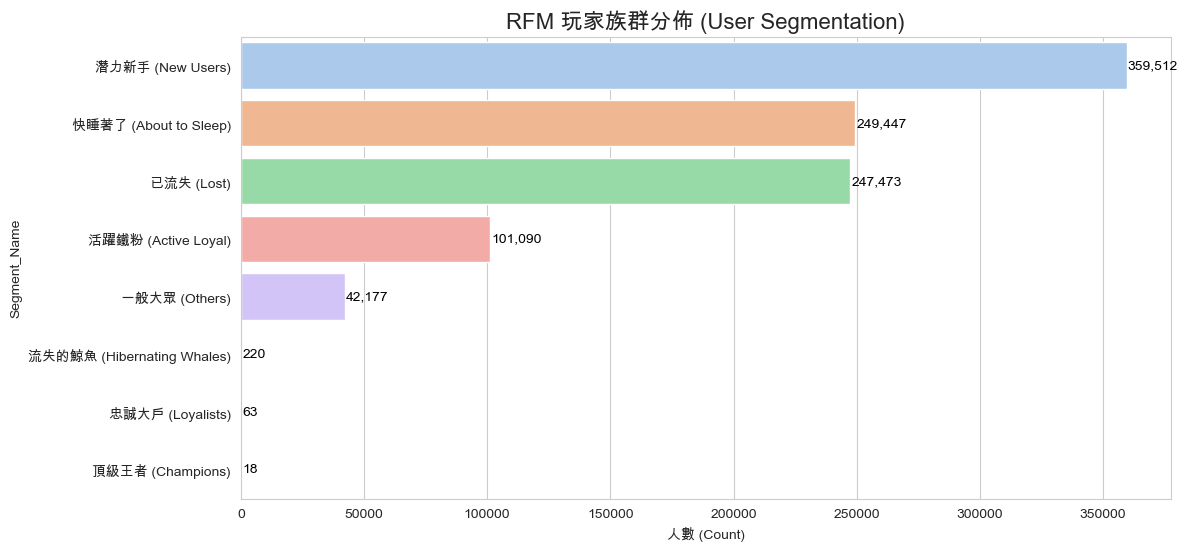

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# 設定繪圖風格 
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 貼標籤 
def map_segment_names(row):
    r, f, m = row['r_score'], row['f_score'], row['m_score']
    rfm = row['rfm_segment']
    
    # --- 第一層：頂級與流失 (最極端的) ---
    if rfm == '444': return '頂級王者 (Champions)'
    elif r == 1 and m == 4: return '流失的鯨魚 (Hibernating Whales)'  # 以前花大錢，現在不來了
    elif r == 1 and m == 1: return '已流失 (Lost)' # 沒花錢又很久沒來
        
    # --- 第二層：活躍用戶 (R分數高) ---
    elif r in [3, 4] and f == 1: return '潛力新手 (New Users)' # 剛來，只玩一次
    elif r in [3, 4] and m in [3, 4]: return '忠誠大戶 (Loyalists)' # 常來且花不少錢
    elif r in [3, 4] and f in [3, 4]: return '活躍鐵粉 (Active Loyal)' # 常來玩 (可能沒花大錢)
        
    # --- 第三層：風險用戶 (R分數低/中) ---
    elif r == 2: return '快睡著了 (About to Sleep)'
        
    # --- 其他 ---
    else: return '一般大眾 (Others)'

df_rfm['Segment_Name'] = df_rfm.apply(map_segment_names, axis=1)

# 各族群人數統計
plt.figure(figsize=(12, 6))
segment_counts = df_rfm['Segment_Name'].value_counts()
ax = sns.barplot(y=segment_counts.index, x=segment_counts.values, palette="pastel",hue=segment_counts.index)

# 標上數字
for i, v in enumerate(segment_counts.values):
    ax.text(v + 500, i, f'{v:,}', color='black', va='center', fontweight='bold')

plt.title('RFM 玩家族群分佈 (User Segmentation)', fontsize=16)
plt.xlabel('人數 (Count)')
plt.show()


## 第五部分：洞察分析

### 1. 總體健檢：典型的漏水水桶體質
#### 觀察來源： 玩家族群分佈長條圖 (人數)

- **現狀：** 獲客能力（Acquisition）極強，「潛力新手」是人數最多的族群（約 36 萬人），顯示廣告投放有效，源源不斷有新血注入。
- **危機：** 留存能力（Retention）堪憂。「快睡著了」加上「已流失」的用戶超過 50 萬人，佔總人數的一半。
- **結論：** 遊戲目前處於**「進得快、出得也快」**的狀態。我們花了行銷預算把人拉進來，但留存不住他們。

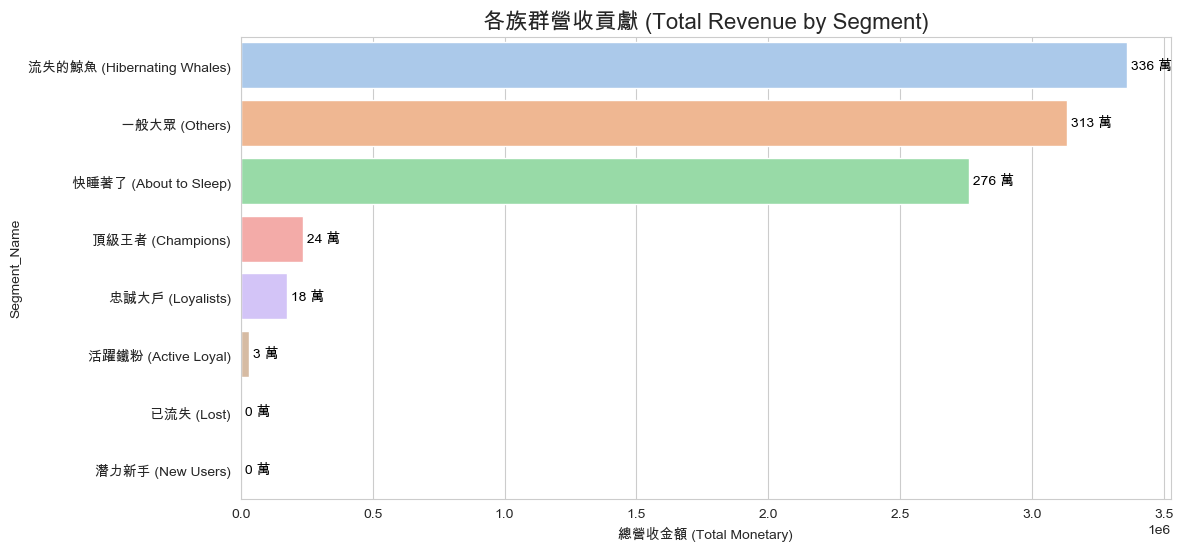

In [10]:
# 各族群營收貢獻
plt.figure(figsize=(12, 6))
segment_revenue = df_rfm.groupby('Segment_Name')['Monetary'].sum().sort_values(ascending=False)
ax_rev = sns.barplot(y=segment_revenue.index, x=segment_revenue.values, palette="pastel",hue=segment_revenue.index)

for i, v in enumerate(segment_revenue.values):
    ax_rev.text(v, i, f' {v/10000:,.0f} 萬', color='black', va='center', fontweight='bold')

plt.title('各族群營收貢獻 (Total Revenue by Segment)', fontsize=16)
plt.xlabel('總營收金額 (Total Monetary)')
plt.show()


### 2. 營收結構：依賴流失者與大眾
#### 觀察來源： 各族群營收貢獻圖 (金額)

- **流失的鯨魚 (The Whales)：**
    - 全服僅有 **220 位**「流失的鯨魚」，卻貢獻了 **336 萬營收**（第一名）。
    - 平均每人貢獻 (ARPU) **$1.5 萬**，是普通玩家的平均每人貢獻 (ARPU) 1,300 倍。
    - **警訊：** 營收最高的族群竟然是這群「已經流失」的人，代表正在失去最有價值的資產。

- **中產 (The Mass)：**
    - 「一般大眾 (Others)」貢獻了 313 萬營收（第二名）。
    - 這群人雖然沒有被歸類為大戶，但積少成多，是支撐遊戲運作的隱形支柱。

- **表現疲軟的忠誠者 (The Loyalists)：**
    - 現存的「忠誠大戶」人數過少（僅 81 人），總營收貢獻甚至不如一般大眾。這代表大戶養成與維護機制出了問題。
 

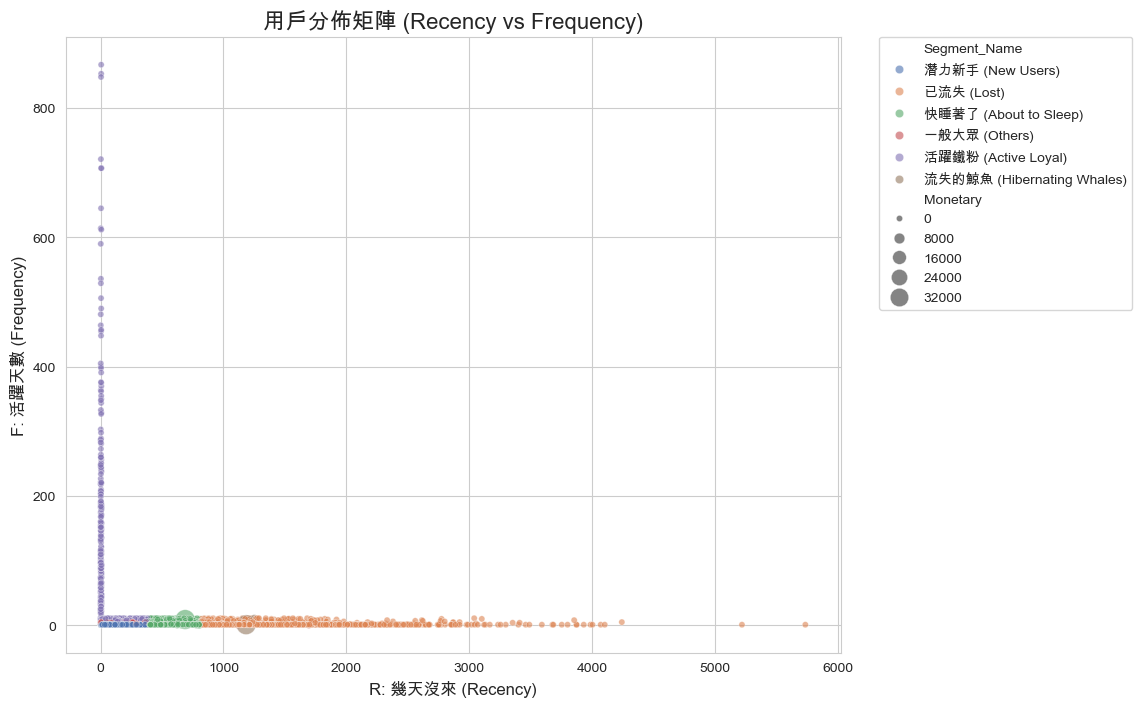

In [11]:
# RFM 分佈矩陣 (Scatter Plot)
# 這張圖能展示用戶的流動路徑與潛在危機
plt.figure(figsize=(10, 8))

# 隨機抽樣 5000 點來代表
df_sample = df_rfm.sample(n=5000, random_state=42)

sns.scatterplot(
    data=df_sample,
    x='Recency',
    y='Frequency',
    hue='Segment_Name',  # 不同族群不同顏色
    size='Monetary',    # 錢花越多的點越大
    sizes=(20, 200),
    alpha=0.6,          
    palette='deep'
)

plt.title('用戶分佈矩陣 (Recency vs Frequency)', fontsize=16)
plt.xlabel('R: 幾天沒來 (Recency)', fontsize=12)
plt.ylabel('F: 活躍天數 (Frequency)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  

plt.show()

### 3. 行為洞察：速食型土豪的殞落
#### 觀察來源： RFM 矩陣散佈圖 (Scatter Plot)

- **L 型分佈：** 玩家呈現極端的兩極化。可能是「死忠鐵粉」（左邊高塔），或者是「玩完即走」（下方長尾）。
- **鯨魚的真相：**
    - 圖表顯示，「流失的鯨魚」大多分佈在 **Y 軸極低（貼地板）** 的位置。
- **解讀：** 這群人不是玩膩了的玩家，而是**「剛進來就狂課金，但幾天內就棄坑」的速食玩家**。
- **推測原因：** 可能是「抽卡體驗極差」、「內容消耗過快（無事可做）」或「付費後的爽感不足」。

###  4. 策略建議 (Action Plan)
根據上述分析，我們提出三大戰略方向：

#### 戰略 A：急救行動 (針對 220 位流失鯨魚)
- **目標：** 召回高客單價流失用戶。
- **建議：尊榮感 + 彌補遺憾**。
    - 由於他們是「玩沒幾天就走」，不要打感情牌（無效）。
    - 直接給予強力的資產誘因（例如：回歸送 T0 角、五星自選券），讓他們覺得「現在回去玩很划算」，或是告訴他們遊戲已經改版，解決了之前的痛點。
- **KPI：** 只要召回 10 人，ROI 即可能轉正。

#### 戰略 B：全面防守 (針對 25 萬位快睡著的玩家)
- **目標：** 阻止一般玩家滑落至「已流失」區間。
- **建議：刷存在感 + 小利誘**。
    - 利用 Push 推播通知、連續登入獎勵、限時體力領取，增加他們打開 App 的頻率。
    - 這群人是營收的基石（雖然人均低，但總量大），必須守住活躍度。

#### 戰略 C：產品優化 (針對新手體驗)
- **目標：** 解決「鯨魚貼地板」的問題。
- **建議：優化首儲體驗 (FTUE)**。
    - 檢查新手期的付費點設計。是不是禮包買了卻變強無感？是不是新手卡池太坑？
    - 如果不能讓大課長在「前三天」感到爽快，我們永遠留不住新的鯨魚。

## 第六部分：A/B 測試策略評估

參與 A/B 測試的有效人數: 364555


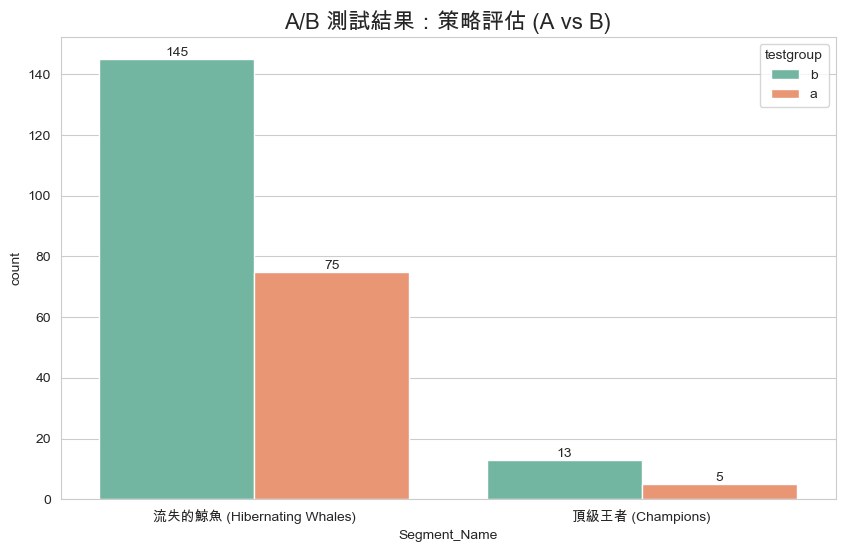

總營收比較
testgroup
a    4851447.0
b    4845553.0
Name: Monetary, dtype: float64
ARPU (人均營收)比較
testgroup
a    26.658939
b    26.540359
dtype: float64


In [32]:
#合併 A/B Test 分組資訊
#將之前整理好的 df_ab (含 uid, testgroup) 合併進來
df_final = pd.merge(df_rfm, df_ab[['uid', 'testgroup']], on='uid', how='left')

#資料清洗：移除未參與實驗的用戶 (NaN)
df_valid = df_final.dropna(subset=['testgroup']).copy()
print(f"參與 A/B 測試的有效人數: {len(df_valid)}")

#關鍵指標分析：王者 vs 流失鯨魚
target_segments = ['頂級王者 (Champions)', '流失的鯨魚 (Hibernating Whales)']
df_targets = df_valid[df_valid['Segment_Name'].isin(target_segments)]

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_targets, x='Segment_Name', hue='testgroup', palette='Set2')
plt.title('A/B 測試結果：策略評估 (A vs B)', fontsize=16)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

# 營收與 ARPU 比較
revenue_compare = df_valid.groupby('testgroup')['Monetary'].sum()
arpu = revenue_compare / df_valid['testgroup'].value_counts()

print("總營收比較")
print(revenue_compare)
print("ARPU (人均營收)比較")
print(arpu)

### 結論與策略建議

### 1. A/B測試比較圖
- **數據對比：**
    - **B組 (綠色,testgroup b)：** 流失鯨魚高達 **145 人**。
    - **A組 (橘色,testgroup a)：** 流失鯨魚只有 **75 人**。
- **B 組製造出的「大課長流失率」是 A 組的將近 2 倍！**

### 2. 數據拼圖：營收的假象
回顧剛剛計算出的營收數據，發現了表面上的和平：
- **總營收：** A組 ($485萬) vs B組 ($484萬) $\rightarrow$ **平手**。
- **ARPU：** A組 ($26.6) vs B組 ($26.5) $\rightarrow$ **平手**。

**洞察：**
既然賺的錢一樣，決策的關鍵就在於**「副作用」**。B 組雖然賺到了同樣的錢，但卻犧牲了兩倍的高價值用戶。

### 3. 最終建議：B 組的策略風險較高
綜合上述分析，針對這次A/B測試的決策建議如下：
數據顯示，B組雖然具備強大的『吸金能力』（讓人掏錢），但它的副作用也強，導致 **大課長流失率是A組的兩倍 (145人 vs 75人)**。
這代表B組是在**『透支』玩家的消費力**。玩家在B組可能因為過度促銷而衝動消費，但買完之後體驗不佳（或覺得被坑了），立刻棄坑。
A組雖然沒有爆發性吸金，但它能以更健康的節奏留住高價值玩家。